## test decoding speed parallel vs loop among other things

In [1]:
%cd ..

D:\ryanh\github\cell_assembly_replay


In [2]:
import numpy as np
import struct
import matplotlib.pyplot as plt

import nelpy as nel
import nelpy.io

import os
import sys
from cell_assembly_replay import functions,replay_run,replay_fig

import pandas as pd
import itertools
import statistics 
import math
from scipy import stats
from nelpy.analysis import replay

from nelpy.decoding import decode1D as decode
from scipy.ndimage import convolve

import multiprocessing
from joblib import Parallel, delayed

import statsmodels.api as sm
import pickle
import copy
from sklearn.isotonic import IsotonicRegression
from scipy.special import cotdg
from skimage.transform import radon
from scipy.stats import multivariate_normal, rv_histogram

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
# output files are saved here
save_path = 'F:/Projects/PAE_PlaceCell/analysis/replay_nelpy/'
# where base data will be read in from
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
# where spike times will be read in
spike_path = 'F:/Projects/PAE_PlaceCell/analysis/spikes/'
# data frame contain info for each unit
df_cell_class = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_recruitment/processed/pyr_int_df.csv')
# data frame contain info for each population burst event
mua_df = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/multiunit_data/post_processed/mua_df.csv')
swr_df = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\swr_data\post_processed\swr_df.csv')


In [4]:
%%time
# import warnings
# warnings.filterwarnings('ignore')
# session = 'LEM3216_S20190718101925'
# session = 'LS19_S20170523165204' 
session = 'LEM3206_S20190718172605' # session with many false positives
verbose = True
# results = run_all(session,data_path,spike_path,save_path,mua_df,df_cell_class,verbose=True)

# def run_all(session,data_path,spike_path,save_path,mua_df,df_cell_class,verbose=False):
"""
Main function that conducts the replay analysis
"""
if verbose:
    print('loading data')
maze_size_cm,pos,st_all = replay_run.get_base_data(data_path,spike_path,session)

# to make everything more simple, lets restrict to just the linear track
pos = pos[0]
st_all = st_all[0]
maze_size_cm = maze_size_cm[0]

# compute and smooth speed
speed1 = nel.utils.ddt_asa(pos, smooth=True, sigma=0.1, norm=True)

# find epochs where the animal ran > 4cm/sec
run_epochs = nel.utils.get_run_epochs(speed1, v1=4, v2=4)

# set up results
results = {}

# loop through each area seperately
areas = df_cell_class.area[df_cell_class.session == session] 
for current_area in pd.unique(areas):
    if verbose:
        print('running through: ',current_area)  

    # subset units to current area
    st = st_all._unit_subset(np.where(areas==current_area)[0]+1)
    # reset unit ids like the other units never existed
    st.series_ids = np.arange(0,len(st.series_ids))+1

    # restrict spike trains to those epochs during which the animal was running
    st_run = st[run_epochs] 
    ds_run = 0.5 
    ds_50ms = 0.05
    # smooth and re-bin:
    #     sigma = 0.3 # 300 ms spike smoothing
    bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=0.3 , inplace=True).rebin(w=ds_run/ds_50ms)

    sigma = 3 # smoothing std dev in cm
    tc = nel.TuningCurve1D(bst=bst_run,
                           extern=pos,
                           n_extern=40,
                           extmin=0,
                           extmax=maze_size_cm,
                           sigma=sigma,
                           min_duration=0)

    # locate pyr cells with >= 100 spikes, peak rate >= 1 Hz, peak/mean ratio >=1.5
    peak_firing_rates = tc.max(axis=1)
    mean_firing_rates = tc.mean(axis=1)
    ratio = peak_firing_rates/mean_firing_rates
    temp_df = df_cell_class[(df_cell_class.session == session) & (df_cell_class.area == current_area)]
    unit_ids_to_keep = (np.where(((temp_df.cell_type == "pyr")) &
                                 (temp_df.n_spikes >=100) &
                                 (tc.ratemap.max(axis=1) >= 1) &
                                 (ratio>=1.5))[0]+1).squeeze().tolist()


    if isinstance(unit_ids_to_keep, int):
        print('warning: only 1 unit')
        results[current_area] = {}
        continue
    elif len(unit_ids_to_keep) == 0:
        print('warning: no units')
        results[current_area] = {}
        continue

    sta_placecells = st._unit_subset(unit_ids_to_keep)
    tc = tc._unit_subset(unit_ids_to_keep)
    total_units = sta_placecells.n_active
    # tc.reorder_units(inplace=True)

    if verbose:
        print('decoding and scoring position')  

# access decoding accuracy on behavioral time scale 
    decoding_r2, median_error, decoding_r2_shuff, _ = replay_run.decode_and_shuff(bst_run.loc[:,unit_ids_to_keep],
                                                                     tc,
                                                                     pos,
                                                                     n_shuffles=1000)
    # check decoding quality against chance distribution
    _, decoding_r2_pval = replay_run.get_significant_events(decoding_r2, decoding_r2_shuff)

    if decoding_r2_pval > 0.05:
        print('warning: poor decoding...skipping')
        results[current_area] = {}
        continue

    # create intervals for PBEs epochs
    # first restrict to current session and to track + pre/post intervals
    temp_df = mua_df[((mua_df.session == session) &
                      ((mua_df.ep_type == "pedestal_1") |
                       (mua_df.ep_type == "track") |
                       (mua_df.ep_type == "pedestal_2")))]

    # restrict to events at least 80ms
    temp_df = temp_df[temp_df.ripple_duration >= 0.08]

    if temp_df.shape[0] == 0:
        print('warning: no PBE events...skipping')
        results[current_area] = {}
        continue

    # make epoch object
    PBEs = nel.EpochArray([np.array([temp_df.start_time,temp_df.end_time]).T])

    # bin data into 20ms 
    bst_placecells = sta_placecells[PBEs].bin(ds=0.02)

    # count units per event
    n_active = [bst.n_active for bst in bst_placecells]
    n_active = np.array(n_active) 
    # restrict bst to instances with >= 5 active units
    idx = n_active >= 5
    bst_placecells = bst_placecells[np.where(idx)[0]]
    # restrict df to instances with >= 5 active units
    temp_df = temp_df[idx]
    n_active = n_active[idx]

    # decode each event
    posteriors, bdries, mode_pth, mean_pth = nel.decoding.decode1D(bst_placecells,
                                                                   tc,
                                                                   xmin=0,
                                                                   xmax=maze_size_cm)
    # score each event using weighted regression, radon, weighted correlation
    if verbose:
        print('scoring events')  
#     (
#         radon_scores,
#         w_corr_scores,
#         radon_pval_time_swap,
#         radon_pval_col_cycle,
#         w_corr_pval_time_swap,
#         w_corr_pval_col_cycle
#     ) = get_scores(bst_placecells,posteriors,bdries,n_shuffles=1000,verbose=verbose)


loading data
running through:  ca3
decoding and scoring position
scoring events
Wall time: 33.2 s


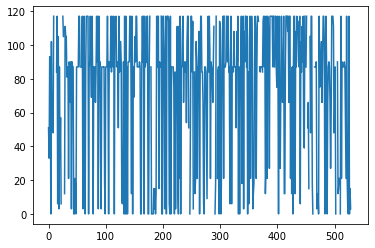

In [14]:
from nelpy.decoding import decode1D as decode
posterior, bdries, mode_pth, mean_pth = decode(bst=bst_placecells, ratemap=tc)
plt.plot(mode_pth)

In [22]:
1/.02

50.0

In [21]:
(120/1)

(120/.02) / (120/1)

# (120/5)*50


50.0

In [15]:

idx = 0
x = np.arange(bdries[idx],bdries[idx+1], step=1)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

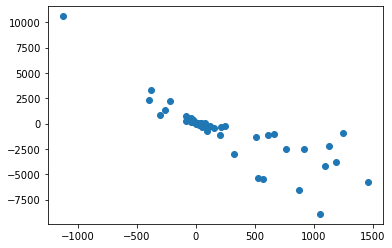

In [23]:
slope, intercept, r2values = replay.linregress_bst(bst_placecells, tc)
plt.scatter(slope*50,intercept)

In [5]:
from nelpy.decoding import decode1D as decode
from tqdm import tqdm

## test out just unit ID and column shuff

In [6]:
def shuff_the_thing(bst_placecells,tc,idx,posterior_array,normalize=True):
    
    bst = replay.unit_id_shuffle_bst(bst_placecells) # better than time_swap_bst & pooled_time_swap_bst  """Create a unit ID shuffled surrogate of BinnedSpikeTrainArray."""
    posterior, bdries, mode_pth, mean_pth = decode(bst=bst,ratemap=tc)
    (
    start_position, 
    velocity, 
    radon_position, 
    score
    ) = replay_run.detect_line_with_radon(
        posterior.T,
        1,  # s
        1,  # cm
        projection_angles=np.arange(-90, 90, 0.5),  # degrees
        filter_invalid_positions=True,
        incorporate_nearby_positions=True,
        nearby_positions_max=3,  # cm
    )
    unit_id_shuffle_bst = replay.trajectory_score_array(posterior=posterior,
                                                         slope=velocity,
                                                         intercept=start_position,
                                                         w=w,
                                                         normalize=normalize)
#     posterior_array = replay.column_cycle_array(posterior_array)
    
#     (
#     start_position, 
#     velocity, 
#     radon_position, 
#     score
#     ) = replay_run.detect_line_with_radon(
#         posterior_array.T,
#         1,  # s
#         1,  # cm
#         projection_angles=np.arange(-90, 90, 0.5),  # degrees
#         filter_invalid_positions=True,
#         incorporate_nearby_positions=True,
#         nearby_positions_max=3,  # cm
#     )
#     scores_col_cycle = replay.trajectory_score_array(posterior=posterior_array,
#                                                      slope=velocity,
#                                                      intercept=start_position,
#                                                      w=w,
#                                                      normalize=normalize)
    return unit_id_shuffle_bst#,scores_col_cycle


num_cores = multiprocessing.cpu_count()         

n_shuffles = 500
w = 3
normalize = True

scores = np.zeros(bst_placecells.n_epochs)

unit_id_shuffle_bst = np.zeros((n_shuffles, bst_placecells.n_epochs))
# scores_col_cycle = np.zeros((n_shuffles, bst_placecells.n_epochs))

posterior, bdries, mode_pth, mean_pth = decode(bst=bst_placecells,ratemap=tc)

for idx in tqdm(range(bst_placecells.n_epochs)):
    posterior_array = posterior[:,bdries[idx]:bdries[idx+1]]
    scores[idx] = replay.trajectory_score_array(posterior=posterior_array,
                                                 w=w,
                                                 normalize=normalize)
    

    unit_id_shuffle_bst[idx] = Parallel(n_jobs=num_cores)(delayed(shuff_the_thing)(
                                                                bst_placecells[int(idx)],
                                                                tc,
                                                                idx,
                                                                posterior_array,
                                                                normalize=normalize
                                                                ) for shflidx in np.arange(n_shuffles))

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [05:24<00:00,  6.91s/it]


In [11]:
np.array(unit_id_shuffle_bst).shape

(500,)

In [10]:
_,unit_id_shuffle_bst_pval = replay.get_significant_events(np.array(scores), np.array(unit_id_shuffle_bst))
# _,scores_col_cycle_pval = replay.get_significant_events(scores, scores_col_cycle)

ValueError: not enough values to unpack (expected 2, got 1)

all


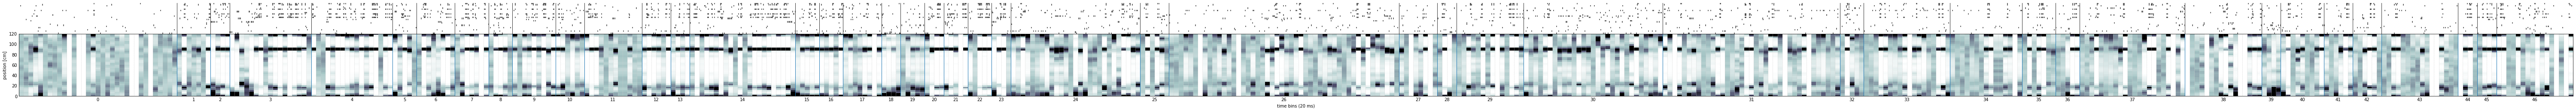

scores_col_cycle_pval [ 4 14 18 19 37 45]


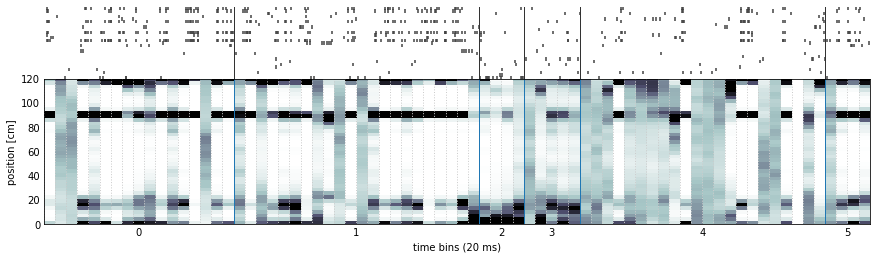

unit_id_shuffle_bst_pval [18 19]


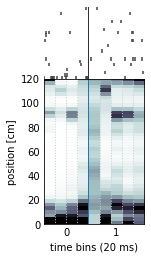

unit_id_shuffle_bst_pval & scores_col_cycle_pval [18 19]


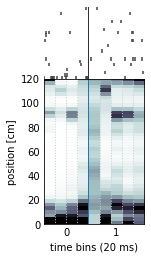

In [18]:
import warnings
warnings.filterwarnings('ignore')
print('all')
ax = replay_fig.plot_all_PBEs(bst_placecells, sta_placecells, tc, tc)
print('scores_col_cycle_pval',np.where(scores_col_cycle_pval < 0.05)[0])
ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(scores_col_cycle_pval < 0.05)[0]], sta_placecells, tc, tc)
print('unit_id_shuffle_bst_pval',np.where(unit_id_shuffle_bst_pval < 0.05)[0])
ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(unit_id_shuffle_bst_pval < 0.05)[0]], sta_placecells, tc, tc)

idx = np.where((unit_id_shuffle_bst_pval < 0.05) & (scores_col_cycle_pval < 0.05 ))[0]
print('unit_id_shuffle_bst_pval & scores_col_cycle_pval',idx)
ax = replay_fig.plot_all_PBEs(bst_placecells[idx], sta_placecells, tc, tc)



## test a bunch of different shuffles

In [451]:
def shuff_the_thing(bst_placecells,tc,idx,posterior_array,normalize=True):
    
    bst = replay.pooled_time_swap_bst(bst_placecells) # """Time swap on BinnedSpikeTrainArray, swapping within entire bst."""
    posterior, bdries, mode_pth, mean_pth = decode(bst=bst,ratemap=tc)
    pooled_time_swap_bst = replay.trajectory_score_array(posterior=posterior[:,bdries[idx]:bdries[idx+1]],
                                                        w=w,
                                                        normalize=normalize)
    
    bst = replay.unit_id_shuffle_bst(bst_placecells) # better than time_swap_bst & pooled_time_swap_bst  """Create a unit ID shuffled surrogate of BinnedSpikeTrainArray."""
    posterior, bdries, mode_pth, mean_pth = decode(bst=bst,ratemap=tc)
    unit_id_shuffle_bst = replay.trajectory_score_array(posterior=posterior[:,bdries[idx]:bdries[idx+1]],
                                                        w=w,
                                                        normalize=normalize)
    
    bst = replay.time_swap_bst(bst_placecells) # """Time swap on BinnedSpikeTrainArray, swapping only within each epoch."""
    posterior, bdries, mode_pth, mean_pth = decode(bst=bst,ratemap=tc)
    time_swap_bst = replay.trajectory_score_array(posterior=posterior[:,bdries[idx]:bdries[idx+1]],
                                                        w=w,
                                                        normalize=normalize)
    
    bst = replay.poisson_surrogate_bst(bst_placecells) #     """Create a Poisson surrogate of BinnedSpikeTrainArray."""
    posterior, bdries, mode_pth, mean_pth = decode(bst=bst,ratemap=tc)
    poisson_surrogate_bst = replay.trajectory_score_array(posterior=posterior[:,bdries[idx]:bdries[idx+1]],
                                                        w=w,
                                                        normalize=normalize)
    
    scores_time_swap = replay.trajectory_score_array(posterior=replay.time_swap_array(posterior_array),
                                                w=w,
                                                normalize=normalize)
    
    scores_col_cycle = replay.trajectory_score_array(posterior=replay.column_cycle_array(posterior_array),
                                                w=w,
                                                normalize=normalize)
            
    return (
        pooled_time_swap_bst,
        unit_id_shuffle_bst,
        time_swap_bst,
        poisson_surrogate_bst,
        scores_time_swap,
        scores_col_cycle
        )

from nelpy.decoding import decode1D as decode
from tqdm import tqdm
num_cores = multiprocessing.cpu_count()         

n_shuffles = 500
w = 3
normalize = True

scores = np.zeros(bst_placecells.n_epochs)

pooled_time_swap_bst = np.zeros((n_shuffles, bst_placecells.n_epochs))
unit_id_shuffle_bst = np.zeros((n_shuffles, bst_placecells.n_epochs))
time_swap_bst = np.zeros((n_shuffles, bst_placecells.n_epochs))
poisson_surrogate_bst = np.zeros((n_shuffles, bst_placecells.n_epochs))
scores_time_swap = np.zeros((n_shuffles, bst_placecells.n_epochs))
scores_col_cycle = np.zeros((n_shuffles, bst_placecells.n_epochs))

posterior, bdries, mode_pth, mean_pth = decode(bst=bst_placecells,ratemap=tc)

for idx in tqdm(range(bst_placecells.n_epochs)):
    posterior_array = posterior[:,bdries[idx]:bdries[idx+1]]
    scores[idx] = replay.trajectory_score_array(posterior=posterior_array,
                                                 w=w,
                                                 normalize=normalize)
    
    (
        pooled_time_swap_bst[:,idx],
        unit_id_shuffle_bst[:,idx],
        time_swap_bst[:,idx],
        poisson_surrogate_bst[:,idx],
        scores_time_swap[:,idx],
        scores_col_cycle[:,idx]
    ) = zip(*Parallel(n_jobs=num_cores)(delayed(shuff_the_thing)(
                                                                bst_placecells,
                                                                tc,
                                                                idx,
                                                                posterior_array,
                                                                normalize=normalize
                                                                ) for shflidx in np.arange(n_shuffles)))
    
#     scores_time_swap_bst[:,idx] = out

    #     for shflidx in range(n_shuffles):
#         # time swap:

#         bst = replay.pooled_time_swap_bst(bst_placecells)
#         posterior, bdries, mode_pth, mean_pth = decode(bst=bst,ratemap=tc)
        
#         scores_time_swap_bst[shflidx, idx] = replay.trajectory_score_array(
#             posterior=posterior,
#             w=w,
#             normalize=normalize)
        

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [12:31<00:00, 16.00s/it]


In [452]:
_,pooled_time_swap_bst_pval = replay.get_significant_events(scores, pooled_time_swap_bst)
_,unit_id_shuffle_bst_pval = replay.get_significant_events(scores, unit_id_shuffle_bst)
_,time_swap_bst_pval = replay.get_significant_events(scores, time_swap_bst)
_,poisson_surrogate_bst_pval = replay.get_significant_events(scores, poisson_surrogate_bst)
_,scores_time_swap_pval = replay.get_significant_events(scores, scores_time_swap)
_,scores_col_cycle_pval = replay.get_significant_events(scores, scores_col_cycle)

pooled_time_swap_bst_pval [ 4 14 18 19]


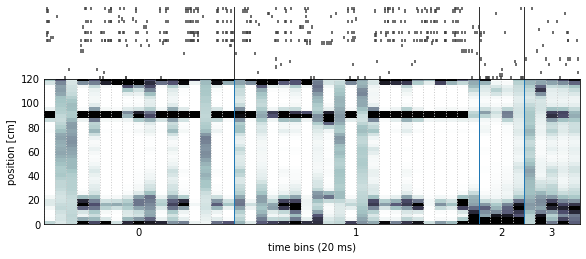

scores_col_cycle_pval [ 4 14 18 19 37 45]


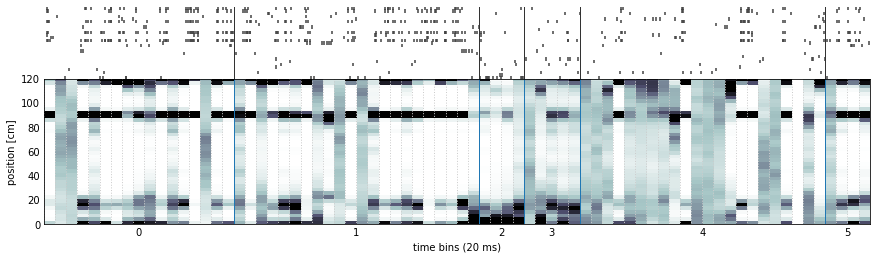

unit_id_shuffle_bst_pval [30 31 37]


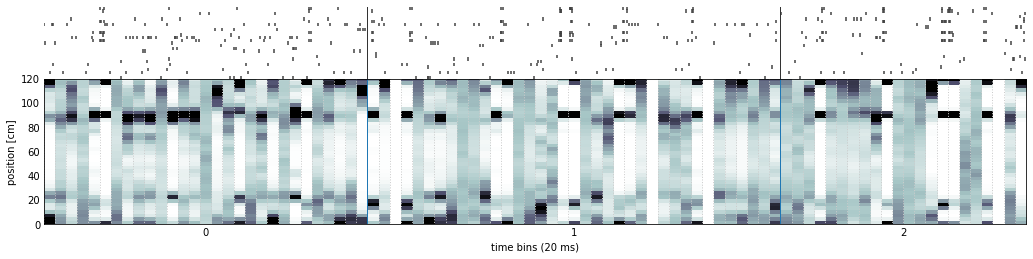

time_swap_bst_pval [ 3  4 19]


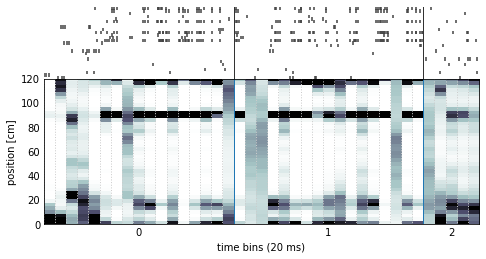

poisson_surrogate_bst_pval [ 4 14 18 19]


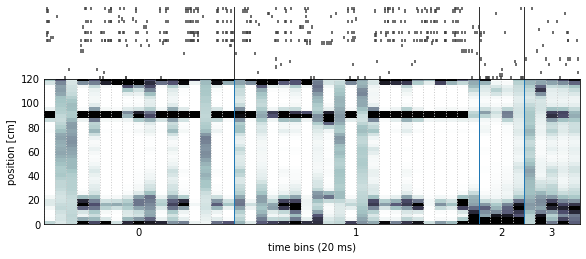

scores_time_swap_pval [ 3  4 19]


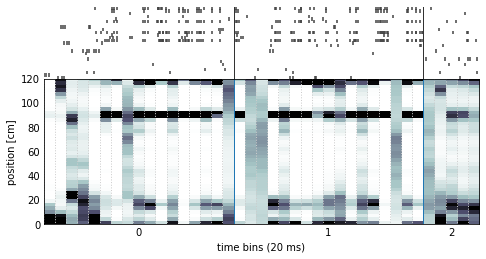

In [453]:
import warnings
warnings.filterwarnings('ignore')

print('pooled_time_swap_bst_pval',np.where(pooled_time_swap_bst_pval < 0.05)[0])
ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(pooled_time_swap_bst_pval < 0.05)[0]], sta_placecells, tc, tc)
print('scores_col_cycle_pval',np.where(scores_col_cycle_pval < 0.05)[0])
ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(scores_col_cycle_pval < 0.05)[0]], sta_placecells, tc, tc)
print('unit_id_shuffle_bst_pval',np.where(unit_id_shuffle_bst_pval < 0.05)[0])
ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(unit_id_shuffle_bst_pval < 0.05)[0]], sta_placecells, tc, tc)
print('time_swap_bst_pval',np.where(time_swap_bst_pval < 0.05)[0])
ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(time_swap_bst_pval < 0.05)[0]], sta_placecells, tc, tc)
print('poisson_surrogate_bst_pval',np.where(poisson_surrogate_bst_pval < 0.05)[0])
ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(poisson_surrogate_bst_pval < 0.05)[0]], sta_placecells, tc, tc)
print('scores_time_swap_pval',np.where(scores_time_swap_pval < 0.05)[0])
ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(scores_time_swap_pval < 0.05)[0]], sta_placecells, tc, tc)


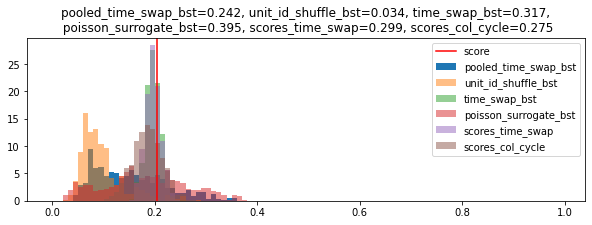

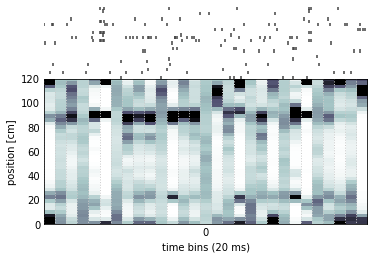

In [470]:
event = 16 # good replay
event = 55 # good replay
event = 29 # good replay
event = 30

plt.figure(figsize = (10,3))
edges = np.arange(0,1,.01)
plt.hist(pooled_time_swap_bst[:,event],label='pooled_time_swap_bst',bins=edges,density=True)
plt.hist(unit_id_shuffle_bst[:,event],label='unit_id_shuffle_bst',alpha=.5,bins=edges,density=True)
plt.hist(time_swap_bst[:,event],label='time_swap_bst',alpha=.5,bins=edges,density=True)
plt.hist(poisson_surrogate_bst[:,event],label='poisson_surrogate_bst',alpha=.5,bins=edges,density=True)
plt.hist(scores_time_swap[:,event],label='scores_time_swap',alpha=.5,bins=edges,density=True)
plt.hist(scores_col_cycle[:,event],label='scores_col_cycle',alpha=.5,bins=edges,density=True)
plt.axvline(scores[event],color='r',label='score')

title = "pooled_time_swap_bst={:.3f}, unit_id_shuffle_bst={:.3f}, time_swap_bst={:.3f},\n poisson_surrogate_bst={:.3f}, scores_time_swap={:.3f}, scores_col_cycle={:.3f}".format(
                                                                                                                                                                        pooled_time_swap_bst_pval[event],
                                                                                                                                                                        unit_id_shuffle_bst_pval[event],
                                                                                                                                                                        time_swap_bst_pval[event],
                                                                                                                                                                        poisson_surrogate_bst_pval[event],
                                                                                                                                                                        scores_time_swap_pval[event],
                                                                                                                                                                        scores_col_cycle_pval[event]
                                                                                                                                                                        )
plt.title(title)
plt.legend()
ax = replay_fig.plot_all_PBEs(bst_placecells[event], sta_placecells, tc, tc)

## notes:
time_swap_bst & scores_time_swap will kick out stationary events 

scores_col_cycle and poisson surrogate bst might work well together


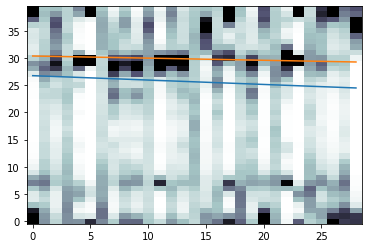

In [471]:
posterior_array = posterior[:,bdries[event]:bdries[event+1]]
slope, intercept, _ = replay.linregress_array(posterior=posterior_array)
x = np.arange(posterior_array.shape[1])
plt.imshow(posterior_array,aspect='auto',origin='lower',vmin=0,vmax=.1,cmap=plt.cm.bone_r)

plt.plot(x,x*slope+intercept)

rsquared,slope,intercept,log_like = replay_run.score_array(posterior_array)
plt.plot(x,x*slope+intercept)

plt.show()

fine_line_scores
Wall time: 183 ms


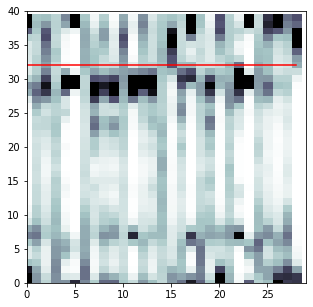

In [475]:
%%time
def sum_between_band(
    Pr,
    slope,
    intercept,
    band_width=7 # pixels 
):
    offset = band_width/2
    line_upper = np.arange(Pr.shape[1])*slope+intercept+offset
    line_lower = np.arange(Pr.shape[1])*slope+intercept-offset
    line_upper_int = np.around(line_upper).astype(int) # Find nearest position bin
    line_lower_int = np.around(line_lower).astype(int) # Find nearest position bin
    
    values = [Pr[line_lower_int[i]:line_upper_int[i],i] for i in range(Pr.shape[1])]
    
    idx = (line_lower_int >= 0) | (line_upper_int >= 0)
    values = [sum(v) for v in values]
    return np.array(values)[idx].sum()

def fine_line(posterior_array):
    intercepts = np.arange(-500,501,2)
    slopes = np.arange(-100,101,25)
    
    coeffs = []
    for b0 in intercepts:
        for b1 in slopes:
            coeffs.append([b0,b1])
    coeffs = np.array(coeffs) 
    idx = (coeffs[:,0] < 0)  & (coeffs[:,1] < 0)
    coeffs = coeffs[~idx,:]
    idx = (coeffs[:,0] > posterior_array.shape[0]) & (coeffs[:,1] > 0)
    coeffs = coeffs[~idx,:]
    
    scores = []
    for b0,b1 in coeffs:
        scores.append(sum_between_band(posterior_array, b1, b0))
    
    idx = np.nanargmax(scores)
    return coeffs[idx,0], coeffs[idx,1], scores[idx] # intercept,slope, score
    
intercept, slope, fine_line_scores = fine_line(posterior_array)

plt.figure(figsize=(5,5))
plt.imshow(posterior_array,aspect='auto',origin='lower',vmin=0,vmax=.1,cmap=plt.cm.bone_r)
x = np.arange(posterior_array.shape[1])

plt.plot(x,x*slope+intercept,color='r')
plt.xlim(0,posterior_array.shape[1])  
plt.ylim(0,posterior_array.shape[0]) 

print('fine_line_scores')

,pooled_time_swap_bst_pval,unit_id_shuffle_bst_pval,time_swap_bst_pval,poisson_surrogate_bst_pval,scores_time_swap_pval,scores_col_cycle_pval
pooled_time_swap_bst_pval,1.000000,0.849120,0.342984,0.979302,0.303819,0.938027
unit_id_shuffle_bst_pval,0.849120,1.000000,0.328619,0.781702,0.287030,0.793655
time_swap_bst_pval,0.342984,0.328619,1.000000,0.343484,0.993749,0.342212
poisson_surrogate_bst_pval,0.979302,0.781702,0.343484,1.000000,0.306350,0.948518
scores_time_swap_pval,0.303819,0.287030,0.993749,0.306350,1.000000,0.308168
scores_col_cycle_pval,0.938027,0.793655,0.342212,0.948518,0.308168,1.000000


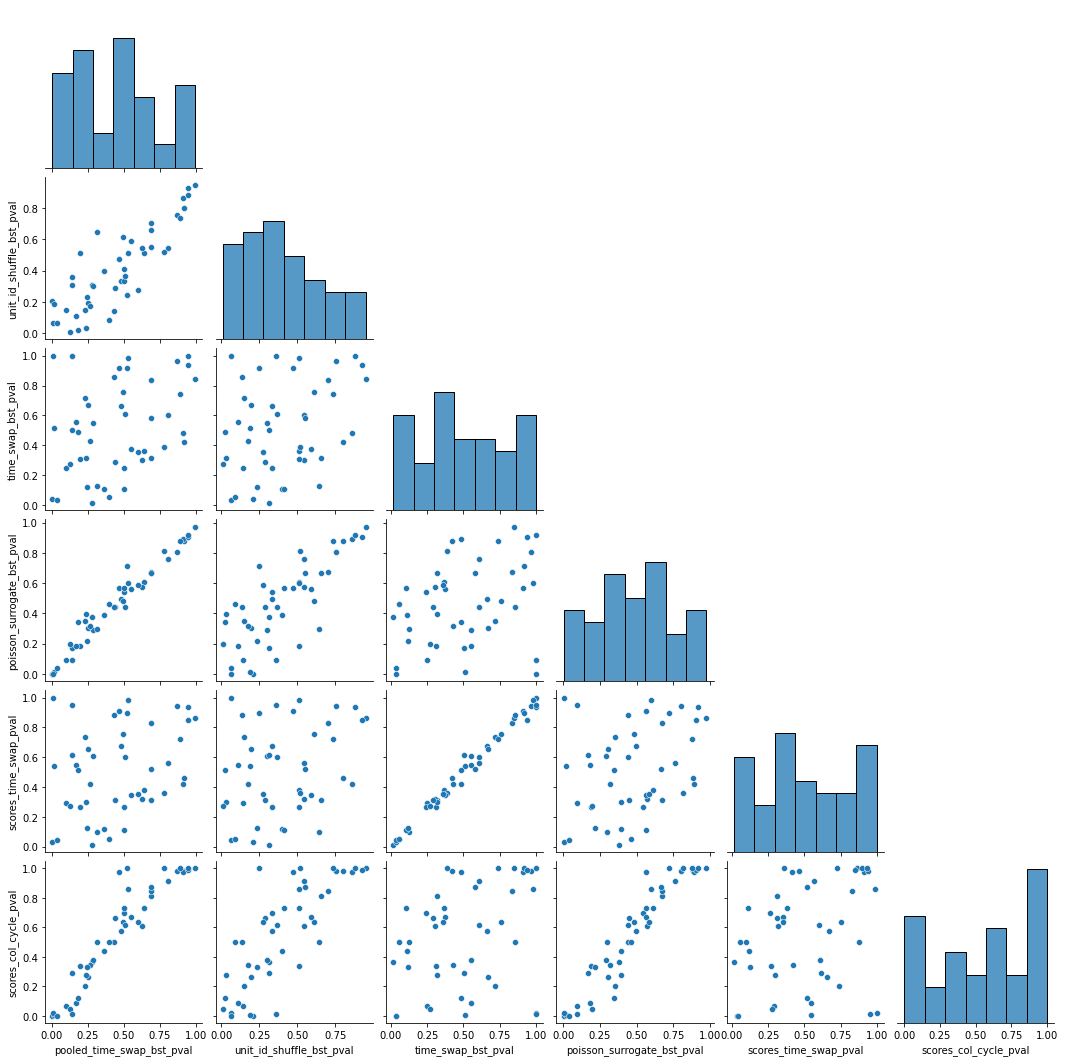

In [454]:
pval_test_df = pd.DataFrame()
pval_test_df['pooled_time_swap_bst_pval'] = pooled_time_swap_bst_pval
pval_test_df['unit_id_shuffle_bst_pval'] = unit_id_shuffle_bst_pval
pval_test_df['time_swap_bst_pval'] = time_swap_bst_pval
pval_test_df['poisson_surrogate_bst_pval'] = poisson_surrogate_bst_pval
pval_test_df['scores_time_swap_pval'] = scores_time_swap_pval
pval_test_df['scores_col_cycle_pval'] = scores_col_cycle_pval

import seaborn as sns
sns.pairplot(pval_test_df,corner=True)
pval_test_df.corr(method ='pearson')

# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\replay_section\pval_comparison.png',dpi=300,bbox_inches='tight')

In [206]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,3))

# ax1.hist(scores_time_swap_bst[:,event],50)
# ax1.axvline(scores[event],color='r')
# title = "new={:.3f}".format(score_pval_time_new[event])
# ax1.set_title(title)

# ax2.hist(scores_time_swap[:,event],50)
# ax2.axvline(scores[event],color='r')
# title = "time swap={:.3f}".format(score_pval_time_swap[event])
# ax2.set_title(title)

# ax3.hist(scores_col_cycle[:,event],50)
# ax3.axvline(scores[event],color='r')
# title = "col cycle={:.3f}".format(score_pval_col_cycle[event])
# ax3.set_title(title)

## pooled_time_swap_bst

    """Time swap on BinnedSpikeTrainArray, swapping within entire bst."""


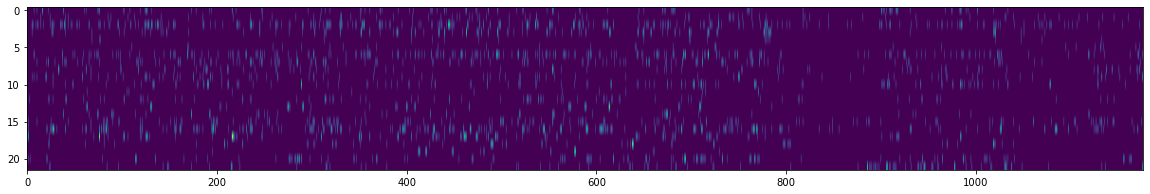

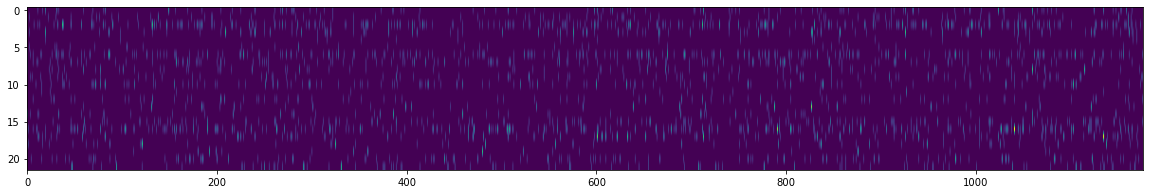

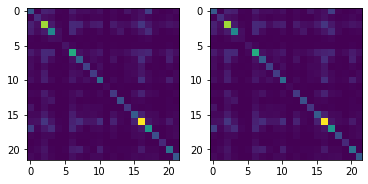

In [122]:
bst = replay.pooled_time_swap_bst(bst_placecells)

plt.figure(figsize=(20,3))
plt.imshow(bst_placecells.data,aspect='auto')

plt.figure(figsize=(20,3))
plt.imshow(bst.data,aspect='auto')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(bst_placecells.data@bst_placecells.data.T)
ax2.imshow(bst.data@bst.data.T)

## time swap

    """Time swap on BinnedSpikeTrainArray, swapping only within each epoch."""


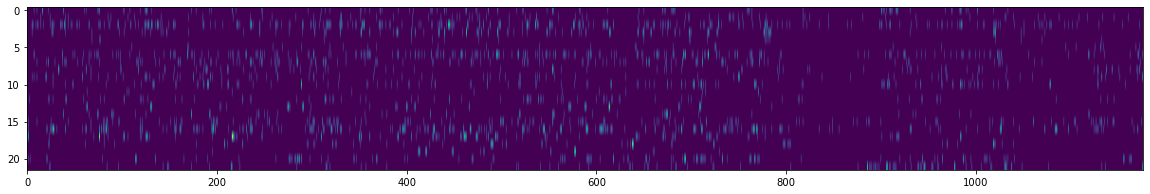

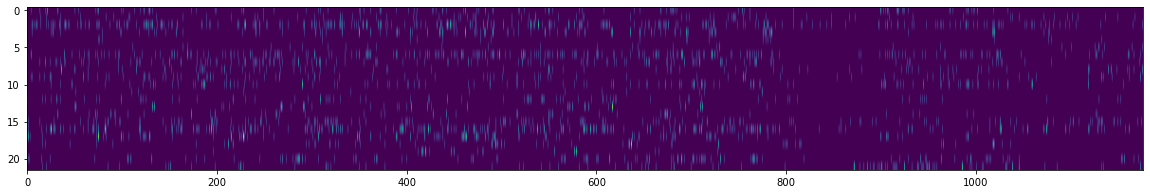

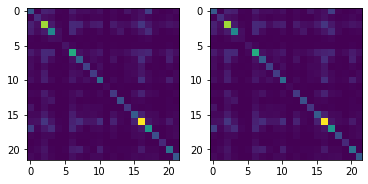

In [26]:
bst = replay.time_swap_bst(bst_placecells)

plt.figure(figsize=(20,3))
plt.imshow(bst_placecells.data,aspect='auto')

plt.figure(figsize=(20,3))
plt.imshow(bst.data,aspect='auto')

fig, (ax1, ax2) = plt.subplots(1, 2)
# plt.figure(figsize=(5,5))
ax1.imshow(bst_placecells.data@bst_placecells.data.T)

# plt.figure(figsize=(5,5))
ax2.imshow(bst.data@bst.data.T)

## incoherent_shuffle_bst

    """Incoherent shuffle on BinnedSpikeTrainArray, swapping only within each epoch."""


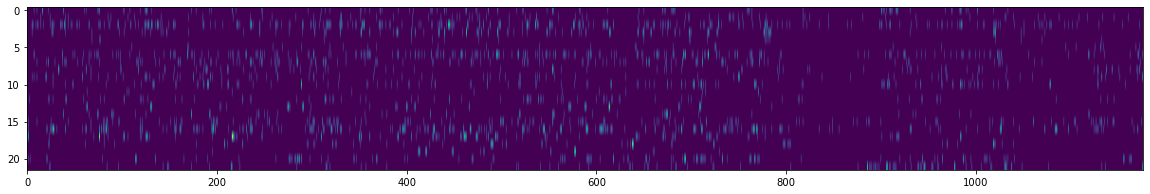

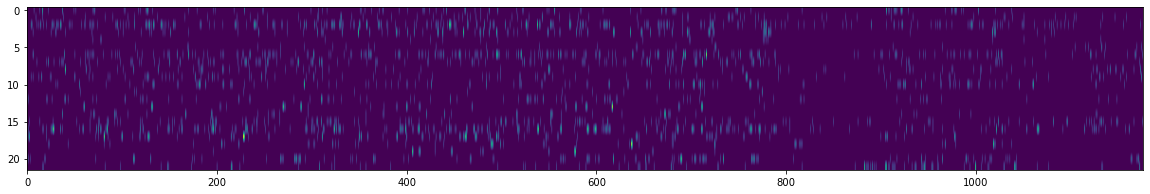

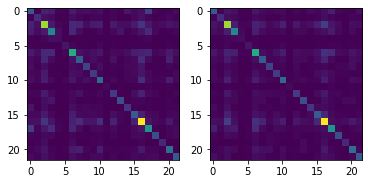

In [33]:
bst = replay.incoherent_shuffle_bst(bst_placecells)

plt.figure(figsize=(20,3))
plt.imshow(bst_placecells.data,aspect='auto')

plt.figure(figsize=(20,3))
plt.imshow(bst.data,aspect='auto')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(bst_placecells.data@bst_placecells.data.T)

ax2.imshow(bst.data@bst.data.T)

## unit_id_shuffle_bst

    """Create a unit ID shuffled surrogate of BinnedSpikeTrainArray."""


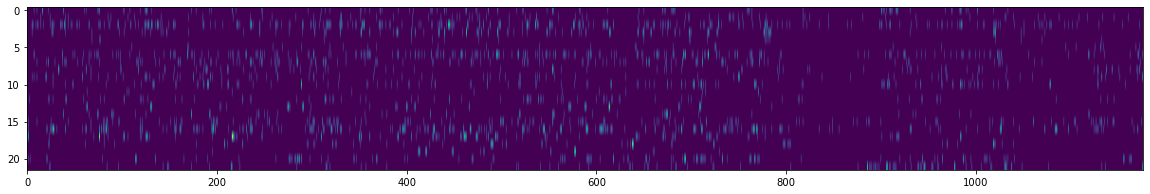

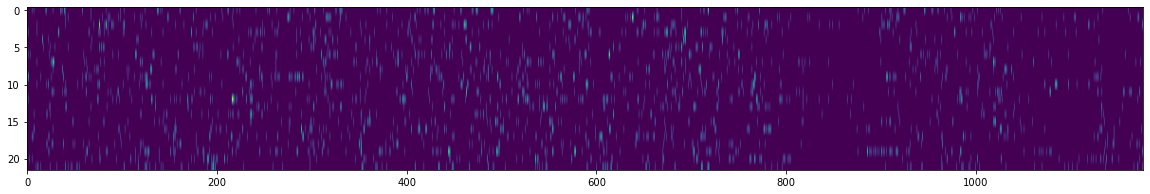

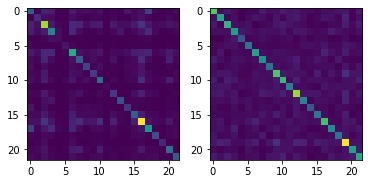

In [37]:
bst = replay.unit_id_shuffle_bst(bst_placecells)

plt.figure(figsize=(20,3))
plt.imshow(bst_placecells.data,aspect='auto')

plt.figure(figsize=(20,3))
plt.imshow(bst.data,aspect='auto')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(bst_placecells.data@bst_placecells.data.T)

ax2.imshow(bst.data@bst.data.T)

# test trajectory score normalization

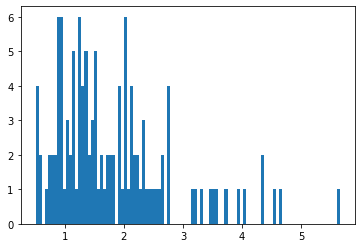

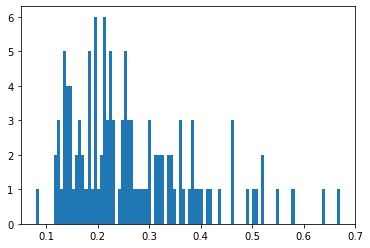

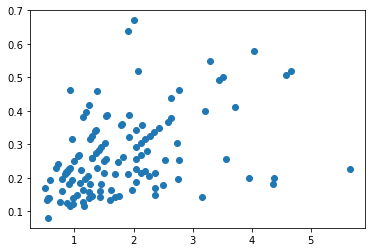

In [30]:
def get_significant_events(scores, shuffled_scores, q=95):
    """Return the significant events based on percentiles.
    NOTE: The score is compared to the distribution of scores obtained
    using the randomized data and a Monte Carlo p-value can be computed
    according to: p = (r+1)/(n+1), where r is the number of
    randomizations resulting in a score higher than (ETIENNE EDIT: OR EQUAL TO?)
    the real score and n is the total number of randomizations performed.
    Parameters
    ----------
    scores : array of shape (n_events,)
    shuffled_scores : array of shape (n_shuffles, n_events)
    q : float in range of [0,100]
        Percentile to compute, which must be between 0 and 100 inclusive.
    Returns
    -------
    sig_event_idx : array of shape (n_sig_events,)
        Indices (from 0 to n_events-1) of significant events.
    pvalues :
    """

    n, _ = shuffled_scores.shape
    r = np.sum(abs(shuffled_scores) >= abs(scores), axis=0)
    pvalues = (r+1)/(n+1)

    # set nan scores to 1
    pvalues[np.isnan(scores)] = 1
    
    sig_event_idx = np.argwhere(scores > np.percentile(
        shuffled_scores,
        axis=0,
        q=q)).squeeze()

    return np.atleast_1d(sig_event_idx), np.atleast_1d(pvalues)

scores,scores_time_swap, scores_col_cycle = replay.trajectory_score_bst(bst_placecells,
                                                 tc,
                                                 w=3,
                                                 n_shuffles=1000)

plt.hist(scores,100)
plt.show()

scores_normalize,scores_time_swap_normalize, scores_col_cycle_normalize = replay.trajectory_score_bst(bst_placecells,
                                                 tc,
                                                 w=3,
                                                 n_shuffles=1000,normalize=True)

plt.hist(scores_normalize,100)
plt.show()

plt.scatter(scores,scores_normalize)

_,score_pval_time_swap = get_significant_events(scores, scores_time_swap)
_,score_pval_col_cycle = get_significant_events(scores, scores_col_cycle)

_,score_pval_time_swap_normalize = get_significant_events(scores_normalize, scores_time_swap_normalize)
_,score_pval_col_cycle_normalize = get_significant_events(scores_normalize, scores_col_cycle_normalize)

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:1590: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


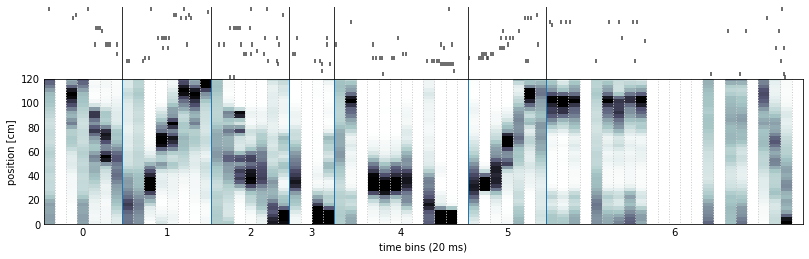

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:1590: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


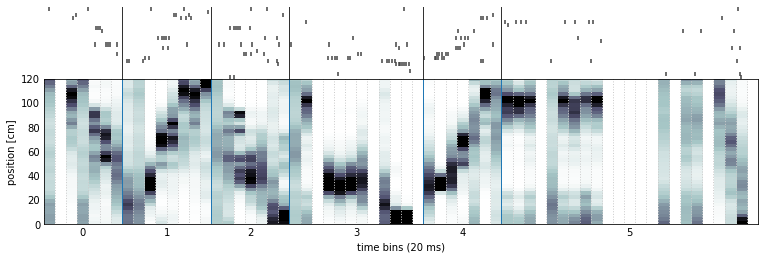

In [38]:
ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(score_pval_time_swap<0.01)[0]], sta_placecells, tc, tc) #idx=np.arange(0,13)
ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(score_pval_time_swap_normalize<0.01)[0]], sta_placecells, tc, tc) #idx=np.arange(0,13)


In [5]:
def score_Davidson_final_bst_fast(bst, tuningcurve, w=None, n_shuffles=2000, n_samples=35000, verbose=False):
    """Compute the trajectory scores from Davidson et al. 2009 for each event
    in the BinnedSpikeTrainArray. DO IT EVEN FASTER!!!
    """

    def sub2ind(n_cols, rows, cols):
        return rows*n_cols + cols

    def calc_ri(NT, NP, phi, rho, ci, ci_mid, ri_mid):
        """
        Note: Not matrix dimensions! Think of dim0 as
        x coordinate, dim1 as y coordinate, etc.
        """
        ri = (rho - (ci - ci_mid) * np.cos(phi)) / np.sin(phi) + ri_mid
        ri = np.around(ri).astype(int) # Find nearest position bin

        return ri

    def _score_line_ri_ci(posterior, precond_posterior, NT, NP, ri, ci, ncols, median_post, nanbins, n_nanbins):

        scores_outside_track = median_post[((ri > NP - 1) & ~nanbins) | ((ri < 0)& ~nanbins)]

        coords = sub2ind(NT, ri, ci)
        coords = coords[(ri < NP) & (ri >= 0) & (~nanbins)]
        scores_within_track = np.take(precond_posterior, coords)

        nanscore = 0
        if n_nanbins > 0:
            nanscore = n_nanbins * np.median(scores_within_track)

        score_within_track = np.sum(scores_within_track)
        score_outside_track = np.sum(scores_outside_track)

        score = score_within_track + score_outside_track

        # we divide by NT later on to be more efficient
        # final_score = score/NT

        return score
    
    def find_best_line(posterior, precond_posterior, phis, rhos, NP, NT, median_post, nanbins, n_nanbins):
        best_score = 0
        best_ri = []

        # n_rows, n_cols = posterior.shape
#         NP, NT = posterior.shape

        ci_mid = (NT + 1)/2 # CONST
        ri_mid = (NP + 1)/2 # CONST
        ci = np.arange(NT)  # CONST
        
        ri = []
        score = []
        for phi, rho in zip(phis, rhos):
            # parameterize line
            ri.append(calc_ri(NT, NP, phi, rho, ci, ci_mid, ri_mid))
            score.append(_score_line_ri_ci(posterior, precond_posterior, NT, NP, ri[-1], ci, NT, median_post, nanbins, n_nanbins))
        return score[np.nanargmax(score)]/NT, ri[np.nanargmax(score)]
    
#     def find_best_line(posterior, precond_posterior, phis, rhos, NP, NT, median_post, nanbins, n_nanbins):
#         best_score = 0
#         best_ri = []

#         # n_rows, n_cols = posterior.shape
# #         NP, NT = posterior.shape

#         ci_mid = (NT + 1)/2 # CONST
#         ri_mid = (NP + 1)/2 # CONST
#         ci = np.arange(NT)  # CONST

#         for phi, rho in zip(phis, rhos):

#             # parameterize line
#             ri = calc_ri(NT, NP, phi, rho, ci, ci_mid, ri_mid)

#             score = _score_line_ri_ci(posterior, precond_posterior, NT, NP, ri, ci, NT, median_post, nanbins, n_nanbins)
#             if score > best_score:
#                 best_score = score
#                 best_ri = ri

#         score = _score_line_ri_ci(posterior, precond_posterior, NT, NP, best_ri, ci, NT, median_post, nanbins, n_nanbins)/NT
#         return score, best_ri
    def shuff_davidson(NP,
                       NT,
                       posterior_cs,
                       precond_posterior_cs,
                       phis,
                       rhos,
                       posterior_median,
                       nanbins,
                       n_nanbins
                      ):

        # do column cycle shuffle on each column independently
        for col in range(NT):
            random_offset = np.random.randint(1, NP)
            posterior_cs[:,col] = np.roll(posterior_cs[:,col], random_offset)
            precond_posterior_cs[:,col] = np.roll(precond_posterior_cs[:,col], random_offset)

        # ideally we should re-sample phi and rho here for every sequence, but to save time, we don't...
        scores_bayes_shuffled, _ = find_best_line(posterior=posterior_cs,
                                                            precond_posterior=precond_posterior_cs,
                                                            phis=phis,
                                                            rhos=rhos,
                                                            NP=NP,
                                                            NT=NT,
                                                            median_post=posterior_median,
                                                            nanbins=nanbins,
                                                            n_nanbins=n_nanbins)
        return scores_bayes_shuffled
        
    if w is None:
        w = 0
    if not float(w).is_integer:
        raise ValueError("w has to be an integer!")

    if float(n_shuffles).is_integer:
        n_shuffles = int(n_shuffles)
    else:
        raise ValueError("n_shuffles must be an integer!")

    posterior, bdries, mode_pth, mean_pth = decode(bst=bst,
                                                   ratemap=tuningcurve)

    # precondition matrix kernel for banded summation
    k = np.zeros((2*w+1, 3))
    k[:,1] = 1

    scores_bayes = np.zeros(bst.n_epochs)
    best_ri = []

    if n_shuffles > 0:
        scores_bayes_shuffled = np.zeros((n_shuffles, bst.n_epochs))
        
    num_cores = multiprocessing.cpu_count()         

    for idx in range(bst.n_epochs):
        if verbose:
            print("scoring event ", idx+1, "/", bst.n_epochs)

        posterior_array = posterior[:, bdries[idx]:bdries[idx+1]]

        # now we zero out all the nan bins (we compensate for them later...)
        nanbins = np.isnan(np.max(posterior_array, axis=0))
        n_nanbins = np.count_nonzero(nanbins)
        posterior_array[:, nanbins] = 0

        # now pre-compute median of entire array
        posterior_median = np.median(posterior_array, axis=0)

        NP, NT = posterior_array.shape

        D = np.sqrt((NT-1)**2 + (NP-1)**2)
        phi_range = (-0.5*np.pi, 0.5*np.pi)
        rho_range = (-0.5*D, 0.5*D)

        phis = phi_range[0] + np.random.rand(n_samples)*(phi_range[1] - phi_range[0])
        phis[(phis < 0.0001) & (phis > -0.0001)] = 0.0001
        rhos = rho_range[0] + np.random.rand(n_samples)*(rho_range[1] - rho_range[0])

        precond_posterior = convolve(posterior_array, k, mode='constant', cval=0.0)

        scores_bayes[idx], best_ri_ = find_best_line(posterior=posterior_array,
                                        precond_posterior=precond_posterior,
                                        phis=phis,
                                        rhos=rhos,
                                        NP=NP,
                                        NT=NT,
                                        median_post=posterior_median,
                                        nanbins=nanbins,
                                        n_nanbins=n_nanbins)
        best_ri.append(best_ri_)
        
        if n_shuffles > 0:
            posterior_cs = copy.deepcopy(posterior_array)
            precond_posterior_cs = copy.deepcopy(precond_posterior)

#             for shflidx in range(n_shuffles):

#                 # do column cycle shuffle on each column independently
#                 for col in range(NT):
#                     random_offset = np.random.randint(1, NP)
#                     posterior_cs[:,col] = np.roll(posterior_cs[:,col], random_offset)
#                     precond_posterior_cs[:,col] = np.roll(precond_posterior_cs[:,col], random_offset)

#                 # ideally we should re-sample phi and rho here for every sequence, but to save time, we don't...
#                 scores_bayes_shuffled[shflidx, idx], _ = find_best_line(posterior=posterior_cs,
#                                                                     precond_posterior=precond_posterior_cs,
#                                                                     phis=phis,
#                                                                     rhos=rhos,
#                                                                     NP=NP,
#                                                                     NT=NT,
#                                                                     median_post=posterior_median,
#                                                                     nanbins=nanbins,
#                                                                     n_nanbins=n_nanbins)
                

                
        scores_bayes_shuffled[:,idx] = Parallel(n_jobs=num_cores)(delayed(shuff_davidson)(NP,
                                                                    NT,
                                                                    posterior_cs,
                                                                    precond_posterior_cs,
                                                                    phis,
                                                                    rhos,
                                                                    posterior_median,
                                                                    nanbins,
                                                                    n_nanbins) for shflidx in range(n_shuffles))
    
    if n_shuffles > 0:
        scores_bayes_shuffled = scores_bayes_shuffled.T
        n_scores = len(scores_bayes)
        scores_bayes_percentile = np.array([stats.percentileofscore(scores_bayes_shuffled[idx], scores_bayes[idx], kind='mean') for idx in range(n_scores)])
        return scores_bayes, scores_bayes_shuffled, scores_bayes_percentile, best_ri
    return scores_bayes

In [45]:
%%time
# idx = 1
# scores, scores_shuffled, percentile,best_ri = score_Davidson_final_bst_fast(bst_placecells,
#                                                                            tc,w=3,n_shuffles=1000,
#                                                                            n_samples=1000,verbose=True) #Davidson method very slow
num_cores = multiprocessing.cpu_count()         
scores, scores_shuffled, percentile,best_ri = zip(*Parallel(n_jobs=num_cores)(delayed(score_Davidson_final_bst_fast)(
                                                                                                bst_placecells[idx],
                                                                                                tc,
                                                                                                w=3,
                                                                                                n_shuffles=1000,
                                                                                                n_samples=1000,
                                                                                                verbose=True
                                                                                                ) for idx in range(bst_placecells.n_epochs)))
# plt.hist(scores_shuffled.T,50)
# plt.axvline(scores,color='r')
# plt.show()
# print(percentile)
# _,davidson_pval = replay_run.get_significant_events(scores, scores_shuffled.T)
# print(davidson_pval)

# posterior_array = posteriors[:, bdries[idx]:bdries[idx+1]]
# plt.imshow(posterior_array,aspect='auto',cmap=plt.cm.bone_r,origin='lower')
# plt.plot(np.arange(best_ri[0].shape[0]),best_ri[0],color='r')

Wall time: 42min 6s


D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:1590: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


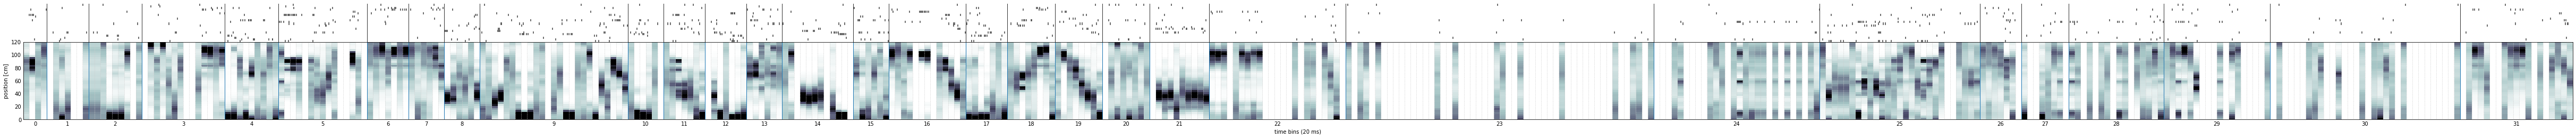

In [38]:
_,davidson_pval = replay_run.get_significant_events(np.array(scores)[:,0],np.array(scores_shuffled).squeeze().T)
# plt.hist(davidson_pval,50)
# plt.show()

ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(davidson_pval<0.05)[0]], sta_placecells, tc, tc) #idx=np.arange(0,13)


In [ ]:
%%time
scores, scores_shuffled, percentile,best_ri = score_Davidson_final_bst_fast(
                                                                            bst_placecells,
                                                                            tc,
                                                                            w=3,
                                                                            n_shuffles=1000,
                                                                            n_samples=1000,
                                                                            verbose=True
                                                                            ) #Davidson method very slow

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:1590: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


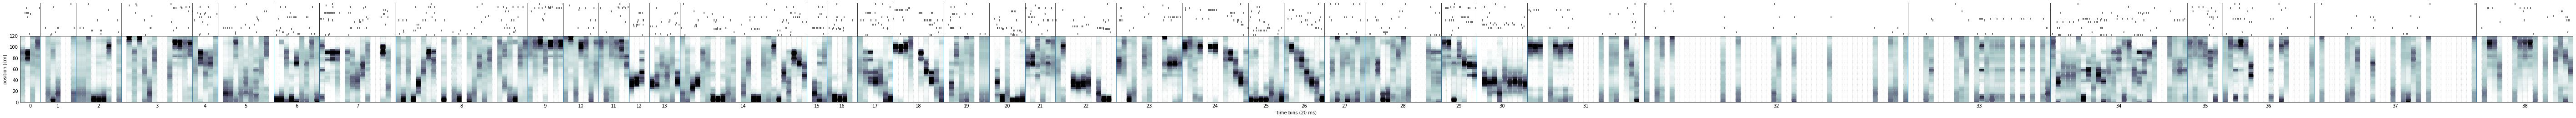

In [44]:
_,davidson_pval = replay_run.get_significant_events(scores,np.array(scores_shuffled).squeeze().T)
# plt.hist(davidson_pval,50)
# plt.show()

ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(davidson_pval<0.05)[0]], sta_placecells, tc, tc) #idx=np.arange(0,13)


In [52]:
%%time
scores, scores_time_swap, scores_col_cycle = replay.trajectory_score_bst(bst_placecells, tc, w=3, n_shuffles=500, normalize=False)

Wall time: 1min 17s


D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:1590: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


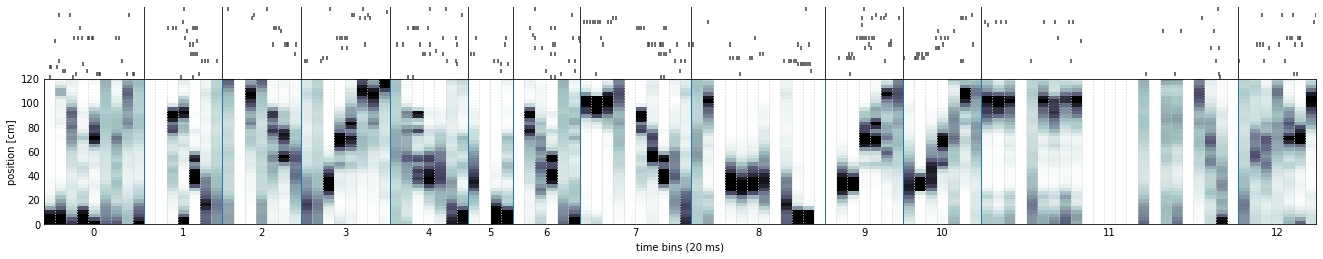

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:1590: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


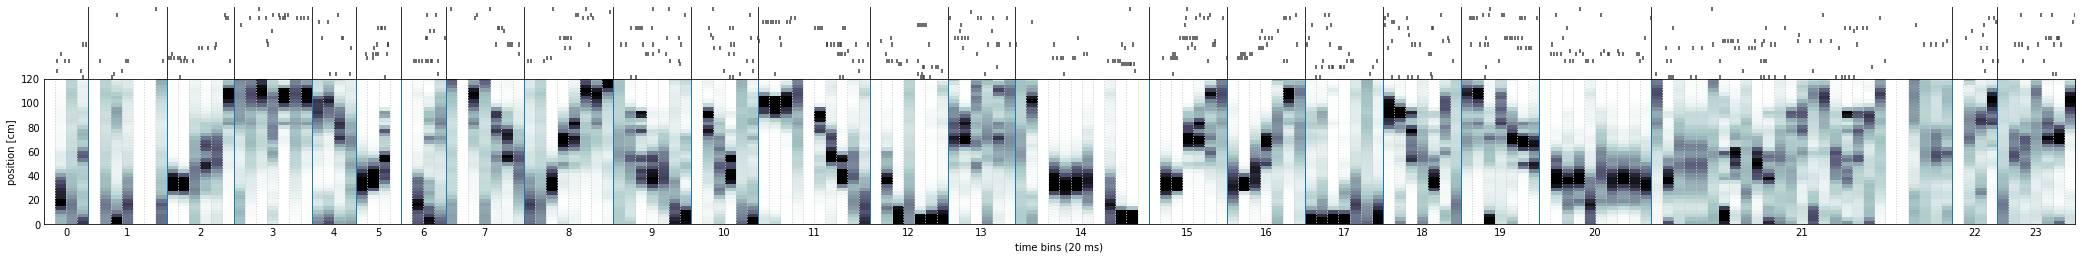

In [56]:
_,trajectory_score_bst_pval = replay_run.get_significant_events(scores,scores_time_swap)

ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(trajectory_score_bst_pval<0.05)[0]], sta_placecells, tc, tc) #idx=np.arange(0,13)


_,trajectory_score_bst_pval = replay_run.get_significant_events(scores,scores_col_cycle)

ax = replay_fig.plot_all_PBEs(bst_placecells[np.where(trajectory_score_bst_pval<0.05)[0]], sta_placecells, tc, tc) #idx=np.arange(0,13)


In [ ]:
%%time
idx = 4
scores, scores_shuffled, percentile,best_ri = score_Davidson_final_bst_fast(bst_placecells[idx],
                                                                           tc,w=0,n_shuffles=1000,
                                                                           n_samples=35000,verbose=True) #Davidson method very slow

plt.hist(scores_shuffled.T,50)
plt.axvline(scores,color='r')
plt.show()
print(percentile)
_,score_Davidson_final_bst_fast = replay_run.get_significant_events(scores, np.expand_dims(scores_shuffled, axis=1))
print(score_Davidson_final_bst_fast)

posterior_array = posteriors[:, bdries[idx]:bdries[idx+1]]
plt.imshow(posterior_array,aspect='auto',cmap=plt.cm.bone_r,origin='lower')
plt.plot(np.arange(best_ri.shape[0]),best_ri,color='r')

D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:158: RuntimeWarning: divide by zero encountered in true_divide
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:158: RuntimeWarning: invalid value encountered in true_divide
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:158: RuntimeWarning: invalid value encountered in subtract
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:199: RuntimeWarning: invalid value encountered in add


Text(0.5, 1.0, '0.6613851924824002')

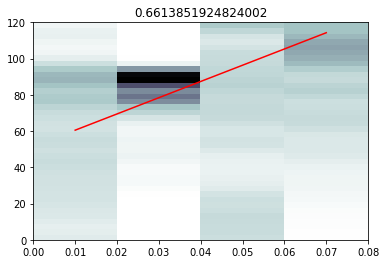

In [235]:
posterior_array = posteriors[:, bdries[idx]:bdries[idx+1]]
posterior_array[np.isnan(posterior_array)] = 0

dt = 0.02
dp = 3
start_position, velocity, radon_position, score = replay_run.detect_line_with_radon(posterior_array.T,dt,dp)

n_time = posterior_array.shape[1]
max_position = 120

time = np.arange(n_time) * dt
place_bin_edges = np.arange(0, max_position + dp, dp)
# place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges) / 2

time_bin_edges = np.arange(n_time+1) * dt

t, p = np.meshgrid(time_bin_edges, place_bin_edges)

plt.pcolormesh(t, p, posterior_array,cmap=plt.cm.bone_r)
plt.plot(time+dt/2,radon_position,color='red')
plt.title(score)

In [184]:
def calc_ri(NT, NP, phi, rho, ci, ci_mid, ri_mid):
    """
    Note: Not matrix dimensions! Think of dim0 as
    x coordinate, dim1 as y coordinate, etc.
    """
    ri = (rho - (ci - ci_mid) * np.cos(phi)) / np.sin(phi) + ri_mid
    ri = np.around(ri).astype(int) # Find nearest position bin

    return ri

NP, NT = posterior_array.shape

ci_mid = (NT + 1)/2 # CONST
ri_mid = (NP + 1)/2 # CONST
ci = np.arange(NT)  # CONST

plt.figure()
ri = []
for phi, rho in zip(phis, rhos):

    # parameterize line
    ri.append(calc_ri(NT, NP, phi, rho, ci, ci_mid, ri_mid))   
#     plt.plot(ri)
# plt.ylim(0,NP)    

def find_best_line(posterior, precond_posterior, phis, rhos, NP, NT, median_post, nanbins, n_nanbins):
    best_score = 0
    best_ri = []

    # n_rows, n_cols = posterior.shape
#         NP, NT = posterior.shape

    ci_mid = (NT + 1)/2 # CONST
    ri_mid = (NP + 1)/2 # CONST
    ci = np.arange(NT)  # CONST

    ri = []
    score = []
    for phi, rho in zip(phis, rhos):

        # parameterize line
        ri.append(calc_ri(NT, NP, phi, rho, ci, ci_mid, ri_mid))

        score.append(_score_line_ri_ci(posterior, precond_posterior, NT, NP, ri[-1], ci, NT, median_post, nanbins, n_nanbins))
#             if score > best_score:
#                 best_score = score
#                 best_ri = ri

    best_ri = ri[np.argmax(score)]
    score = _score_line_ri_ci(posterior, precond_posterior, NT, NP, best_ri, ci, NT, median_post, nanbins, n_nanbins)/NT
    return score, best_ri

<Figure size 432x288 with 0 Axes>

In [188]:
print(ri[-1])


[5 4 3 2 1 0]


In [142]:
ri_t = np.array(ri).T

In [146]:
ri_t[:,0:10]

array([[ -13,   11,   15,   39,   37,   74,   20,   36, -406,   84],
       [ -12,   10,   15,   38,   38,   72,   21,   36, -388,   82],
       [ -11,   10,   16,   37,   39,   69,   21,   37, -370,   79],
       [ -10,    9,   16,   37,   40,   67,   21,   37, -351,   76],
       [  -8,    9,   16,   36,   41,   64,   21,   37, -333,   74],
       [  -7,    8,   16,   35,   42,   62,   21,   38, -314,   71]])

In [ ]:
plt.plot(ri_t,color='k',alpha=.2)
plt.ylim(0,NP)
plt.show()

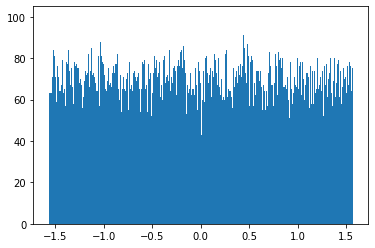

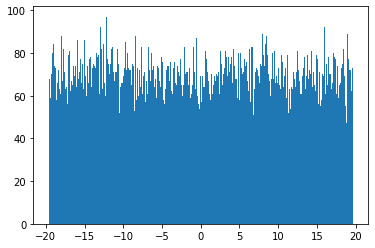

In [135]:
n_samples = 35000
NP, NT = posterior_array.shape

D = np.sqrt((NT-1)**2 + (NP-1)**2)
phi_range = (-0.5*np.pi, 0.5*np.pi)
rho_range = (-0.5*D, 0.5*D)

phis = phi_range[0] + np.random.rand(n_samples)*(phi_range[1] - phi_range[0])
phis[(phis < 0.0001) & (phis > -0.0001)] = 0.0001
rhos = rho_range[0] + np.random.rand(n_samples)*(rho_range[1] - rho_range[0])

plt.figure()
plt.hist(phis,500)
plt.show()

plt.figure()
plt.hist(rhos,500)
plt.show()

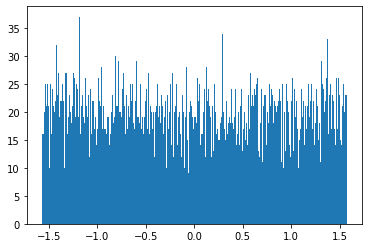

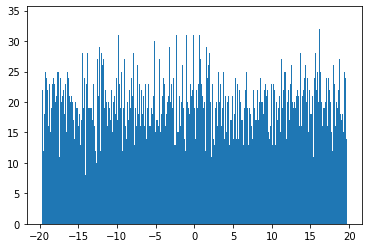

In [110]:
n_samples = 10000
NP, NT = posterior_array.shape

D = np.sqrt((NT-1)**2 + (NP-1)**2)
phi_range = (-0.5*np.pi, 0.5*np.pi)
rho_range = (-0.5*D, 0.5*D)

phis = phi_range[0] + np.random.uniform(size=n_samples)*(phi_range[1] - phi_range[0])
phis[(phis < 0.0001) & (phis > -0.0001)] = 0.0001
rhos = rho_range[0] + np.random.uniform(size=n_samples)*(rho_range[1] - rho_range[0])


plt.figure()
plt.hist(phis,500)
plt.show()

plt.figure()
plt.hist(rhos,500)
plt.show()

In [ ]:
def shuff(posterior_array,time,place_bin_centers,dt,dp):
    
    posterior_ts = replay.time_swap_array(posterior_array)
    posterior_cs = replay.column_cycle_array(posterior_array)

    radon_time_swap = replay_run.detect_line_with_radon(posterior_ts,
                                            dt,
                                            dp,
                                            incorporate_nearby_positions=False)
    
    radon_col_cycle = replay_run.detect_line_with_radon(posterior_cs,
                                            dt,
                                            dp,
                                            incorporate_nearby_positions=False)

    w_corr_time_swap = replay_run.weighted_correlation(posterior_ts, time, place_bin_centers)
    w_corr_col_cycle = replay_run.weighted_correlation(posterior_cs, time, place_bin_centers)
    
    return radon_time_swap[-1],radon_col_cycle[-1],w_corr_time_swap,w_corr_col_cycle

def get_scores(bst, posterior, bdries, n_shuffles=1000,dt=0.02,dp=3,max_position=120,verbose=False):
    """
    runs score_array on observed data and then conducts a shuffle analysis using
    two types of procedures (time swap and column cycle).
    
    Will run through each epoch in your binned spike train
    """

    place_bin_edges = np.arange(0, max_position + dp, dp)
    place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges) / 2
        
    radon_scores = np.zeros(bst.n_epochs)
    w_corr_scores = np.zeros(bst.n_epochs)
    radon_pval_time_swap = np.zeros(bst.n_epochs)
    radon_pval_col_cycle = np.zeros(bst.n_epochs)
    w_corr_pval_time_swap = np.zeros(bst.n_epochs)
    w_corr_pval_col_cycle = np.zeros(bst.n_epochs) 
    
    # get n cores to know how many jobs to run  
    num_cores = multiprocessing.cpu_count()         
    
    for idx in range(bst.n_epochs):
        if verbose:
            print('event: ',str(idx),' of ',str(bst.n_epochs))
            
        posterior_array = posterior[:, bdries[idx]:bdries[idx+1]].T
        _, _, _, radon_scores[idx] = replay_run.detect_line_with_radon(posterior_array,
                                                            dt,
                                                            dp,
                                                            incorporate_nearby_positions=False)
        time = bst[idx].bin_centers
        w_corr_scores[idx] = replay_run.weighted_correlation(posterior_array, time, place_bin_centers)
            
        (
            radon_time_swap,
            radon_col_cycle,
            w_corr_time_swap,
            w_corr_col_cycle
        ) = zip(*Parallel(n_jobs=num_cores)(delayed(shuff)(posterior_array,
                                                           time,
                                                           place_bin_centers,
                                                           dt,
                                                           dp) for i in range(n_shuffles)))
        
        _,radon_pval_time_swap[idx] = replay_run.get_significant_events(radon_scores[idx], np.expand_dims(radon_time_swap, axis=1))
        _,radon_pval_col_cycle[idx] = replay_run.get_significant_events(radon_scores[idx], np.expand_dims(radon_col_cycle, axis=1))
        _,w_corr_pval_time_swap[idx] = replay_run.get_significant_events(w_corr_scores[idx], np.expand_dims(w_corr_time_swap, axis=1))
        _,w_corr_pval_col_cycle[idx] = replay_run.get_significant_events(w_corr_scores[idx], np.expand_dims(w_corr_col_cycle, axis=1))
        
    return (
        radon_scores,
        w_corr_scores,
        radon_pval_time_swap,
        radon_pval_col_cycle,
        w_corr_pval_time_swap,
        w_corr_pval_col_cycle
    )

(
    radon_scores,
    w_corr_scores,
    radon_pval_time_swap,
    radon_pval_col_cycle,
    w_corr_pval_time_swap,
    w_corr_pval_col_cycle
) = get_scores(bst_placecells,posteriors,bdries,n_shuffles=500,verbose=True)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

def shuff(bst,posterior,place_bin_centers,dt,dp,i,radon_scores_ts,radon_scores_cs,w_corr_time_swap,w_corr_col_cycle):
    posterior_ts = replay.time_swap_array(posterior)
    posterior_cs = replay.column_cycle_array(posterior)

    if verbose:
        print('event: ',str(i))   

    for idx in range(bst.n_epochs): 

        time = bst[idx].bin_centers

        posterior_array_ts = posterior_ts[:, bdries[idx]:bdries[idx+1]].T
        posterior_array_cs = posterior_cs[:, bdries[idx]:bdries[idx+1]].T

        _, _, _, radon_scores_ts[i,idx] = replay_run.detect_line_with_radon(posterior_array_ts, dt, dp)
        _, _, _, radon_scores_cs[i,idx] = replay_run.detect_line_with_radon(posterior_array_cs, dt, dp)

        w_corr_time_swap[i,idx] = replay_run.weighted_correlation(posterior_array_ts, time, place_bin_centers)
        w_corr_col_cycle[i,idx] = replay_run.weighted_correlation(posterior_array_cs, time, place_bin_centers)

    return radon_scores_ts,radon_scores_cs,w_corr_time_swap,w_corr_col_cycle


def get_scores(bst, posterior, bdries, n_shuffles=1000,dt=0.02,dp=3,max_position=120,verbose=False):
    """
    runs score_array on observed data and then conducts a shuffle analysis using
    two types of procedures (time swap and column cycle).
    
    Will run through each epoch in your binned spike train
    """

    place_bin_edges = np.arange(0, max_position + dp, dp)
    place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges) / 2
        
    radon_scores = np.zeros(bst.n_epochs)
    w_corr_scores = np.zeros(bst.n_epochs)
    radon_pval_time_swap = np.zeros(bst.n_epochs)
    radon_pval_col_cycle = np.zeros(bst.n_epochs)
    w_corr_pval_time_swap = np.zeros(bst.n_epochs)
    w_corr_pval_col_cycle = np.zeros(bst.n_epochs) 
    
    radon_scores_ts = np.zeros((n_shuffles,bst.n_epochs)) 
    radon_scores_cs = np.zeros((n_shuffles,bst.n_epochs)) 
    w_corr_time_swap = np.zeros((n_shuffles,bst.n_epochs)) 
    w_corr_col_cycle = np.zeros((n_shuffles,bst.n_epochs))
    
    # get n cores to know how many jobs to run  
    num_cores = multiprocessing.cpu_count()         
    
    (
        radon_scores_ts,
        radon_scores_cs,
        w_corr_time_swap,
        w_corr_col_cycle
    ) = zip(*Parallel(n_jobs=num_cores)(delayed(shuff)(bst,posterior,
                                                   place_bin_centers,
                                                   dt,
                                                   dp,i,radon_scores_ts,radon_scores_cs,w_corr_time_swap,w_corr_col_cycle) for i in range(n_shuffles)))

#     for i in range(n_shuffles):
#         posterior_ts = replay.time_swap_array(posterior)
#         posterior_cs = replay.column_cycle_array(posterior)
        
#         if verbose:
#             print('event: ',str(i),' of ',str(n_shuffles))   
        
#         for idx in range(bst.n_epochs): 
            
#             time = bst[idx].bin_centers

#             posterior_array_ts = posterior_ts[:, bdries[idx]:bdries[idx+1]].T
#             posterior_array_cs = posterior_cs[:, bdries[idx]:bdries[idx+1]].T

#             _, _, _, radon_scores_ts[i,idx] = replay_run.detect_line_with_radon(posterior_array_ts, dt, dp)
#             _, _, _, radon_scores_cs[i,idx] = replay_run.detect_line_with_radon(posterior_array_cs, dt, dp)
            
#             w_corr_time_swap[i,idx] = replay_run.weighted_correlation(posterior_array_ts, time, place_bin_centers)
#             w_corr_col_cycle[i,idx] = replay_run.weighted_correlation(posterior_array_cs, time, place_bin_centers)
        

(
    radon_scores,
    w_corr_scores,
    radon_pval_time_swap,
    radon_pval_col_cycle,
    w_corr_pval_time_swap,
    w_corr_pval_col_cycle
) = get_scores(bst_placecells,posteriors,bdries,n_shuffles=1000,verbose=True)


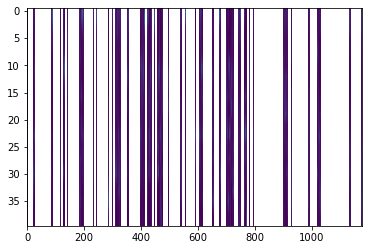

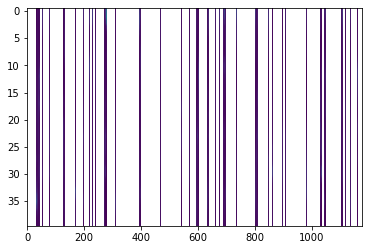

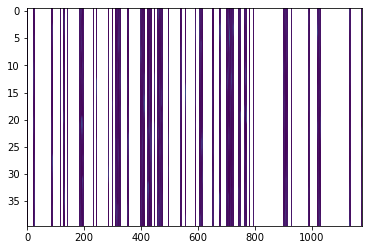

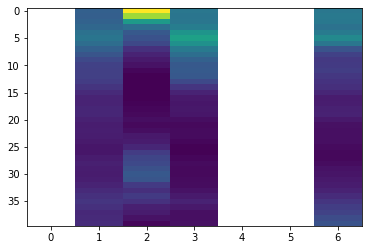

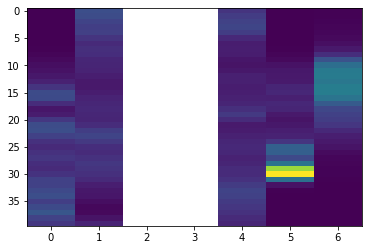

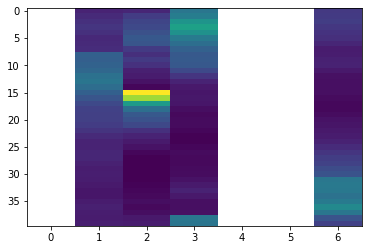

In [25]:
plt.figure()
plt.imshow(posteriors,aspect='auto')
plt.figure()
plt.imshow(posterior_ts,aspect='auto')
plt.figure()
plt.imshow(posterior_cs,aspect='auto')

idx = 2
posterior_array = posteriors[:, bdries[idx]:bdries[idx+1]]
plt.figure()
plt.imshow(posterior_array,aspect='auto')

plt.figure()
posterior_array = posterior_ts[:, bdries[idx]:bdries[idx+1]]
plt.imshow(posterior_array,aspect='auto')

plt.figure()
posterior_array = posterior_cs[:, bdries[idx]:bdries[idx+1]]
plt.imshow(posterior_array,aspect='auto')

In [26]:
%%time
posterior = posteriors
posterior_ts = replay.time_swap_array(posterior)
posterior_cs = replay.column_cycle_array(posterior)

Wall time: 34.9 ms
